In [1]:
#import urllib, urllib3
from bs4 import BeautifulSoup
import requests
import time
import io
import numpy as np
#import nltk
#from nltk.corpus import wordnet as wn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel

Downloading abstracts and from computer science papers using [arXiv.org](https://arxiv.org) API and group them by years:

In [143]:
import os
import pandas as pd
def load_pickle_df(filename):
    if not os.path.exists(filename):
        print("Error file does not exist")
    else:
        print("Loading file: "+filename)
        return pd.read_pickle(filename)
def combine_pickles_to_df(path):
    for idx,e in enumerate(os.listdir(path)):
        if (e == ".ipynb_checkpoints"):
            continue
        file_path = path+e
        if idx == 0:
            dff = load_pickle_df(file_path)
            print(len(dff))
        else:
            df = load_pickle_df(file_path)
            print(len(df))
            dff = dff.append(df,ignore_index=True)
    return dff

In [144]:
path_pickles = "pickles/"
dff = combine_pickles_to_df(path_pickles)
len(dff)
dff = dff.loc[dff.astype(str).drop_duplicates().index]
len(dff)

Loading file: pickles/arxiv_data_cat_20180815175209_to_20190606175609_1560075418.pickle.bz2
45800
Loading file: pickles/arxiv_data_cat_20170330060449_to_20180323224052_1560076229.pickle.bz2
5970
Loading file: pickles/arxiv_data_cs_201001010000_to_20170909215812_1560040808.pickle.bz2
49600
Loading file: pickles/arxiv_data_cat_201001010000_to_20120905175052_1560072901.pickle.bz2
24438
Loading file: pickles/arxiv_data_cat_201001010000_to_20151226190200_1560070379.pickle.bz2
50000


160722

In [145]:
dff[:1]

,id,updated,published,title,summary,authors,affiliations,doi,journal_ref,pdf_link,primary_category,categories
0,http://arxiv.org/abs/1906.02739v1,2019-06-06T17:56:09Z,2019-06-06T17:56:09Z,Mesh R-CNN,Rapid advances in 2D perception have led to sy...,"[Georgia Gkioxari, Jitendra Malik, Justin John...",[],None,None,http://arxiv.org/pdf/1906.02739v1,cs.CV,[cs.CV]


In [146]:
dff.id[:2][0]

'http://arxiv.org/abs/1906.02739v1'

In [147]:
def clean_id(s):
    if s:
        s = re.sub('.*(abs\/)', '', s)
        s = re.sub('.*(cs\/)', '', s)
        s = re.sub('\..*$', '', s)
        return s.strip()
    return s

dff_ids_y_m = dff.id.map(clean_id)

In [151]:
dff_ids_y_m[:1]

0    1906
Name: id, dtype: object

In [152]:
dff_ids_y_m[0]

'1906'

In [153]:
len(dff_ids_y_m)

160722

In [154]:
s_full = list(dff_ids_y_m)
len(s_full)

160722

In [155]:
s_y_m = list(dff_ids_y_m)
s_y_m[31713]

'0201024v2'

In [158]:
s_y_m_test = list(map(lambda x: x[0:4], dff_ids_y_m))
s_y_m_test[31713]

'0201'

In [159]:
s_y_m = list(map(lambda x: x[0:4], dff_ids_y_m))

papers_y_m = pd.DataFrame(columns=['Year', 'Month', 'Papers'])

for i, item in enumerate(set(s_y_m)):
    if s_y_m.count(item) > 1:
        papers_y_m.loc[i, 'Year'] = item[0:2]
        papers_y_m.loc[i, 'Month'] = item[2:4]
        papers_y_m.loc[i, 'Papers'] = s_y_m.count(item)

papers_y_m.sort_values('Year', inplace=True)
papers_y_m.sort_values('Month', inplace=True, ascending=False)
papers_y_m.reset_index(inplace=True, drop=True)
papers_y_m['Year'] = papers_y_m['Year'].astype(int) + 2000
papers_y_m

,Year,Month,Papers
0,2014,12,1543
1,2015,12,1539
2,2013,12,1339
3,2018,12,3454
4,2010,12,640
5,2012,12,219
6,2016,12,2026
7,2017,12,275
8,2011,12,722
9,2014,11,1300


In [100]:
dff_ids.str.slice(stop=2)[60000]

'17'

In [127]:
"cs" in s_y

True

In [128]:
s_y.index("cs")

31712

In [160]:
s_y = list(map(lambda x: x[0:4], dff_ids_y_m.str.slice(stop=2)))

papers_y = pd.DataFrame(columns=['Year', 'Papers'])

for i, item in enumerate(set(s_y)):
    if s_y.count(item) > 1:
        papers_y.loc[i, 'Year'] = item
        papers_y.loc[i, 'Papers'] = s_y.count(item)

papers_y.sort_values('Year', inplace=True)
papers_y.reset_index(inplace=True, drop=True)
#papers_y['Year'] = papers_y['Year'].astype(int) + 2000
papers_y

,Year,Papers
0,08,2
1,09,4
2,10,7509
3,11,9061
4,12,8647
5,13,12517
6,14,16308
7,15,18798
8,16,23581
9,17,21269


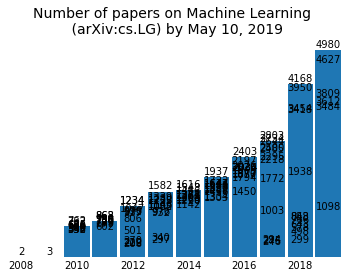

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(papers_y_m['Year'], papers_y_m['Papers'], width=0.9)
#plt.axis('off')
ax = plt.gca()
ax.set_title("Number of papers on Machine Learning \n (arXiv:cs.LG) by May 10, 2019", size=14)
ax.set_xlim(2007.5, 2019.5)

rects = ax.patches
labels = [papers_y_m.loc[i, 'Papers'] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 15, label, ha='center', va='bottom', color='black')

ax.tick_params(axis ='x', which='minor', length=0)
ax.tick_params(axis ='both', which='major', length=0)
ax.set_yticklabels = ['']
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("WEM-arXiv-visual-cs.png", format="png", transparent=True,rasterized=True,dpi=300)
plt.show()

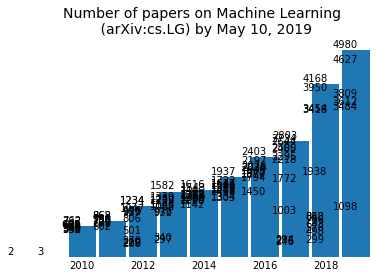

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(papers_y_m['Year'], papers_y_m['Papers'], width=0.9)
#plt.axis('off')
ax = plt.gca()
ax.set_title("Number of papers on Machine Learning \n (arXiv:cs.LG) by May 10, 2019", size=14)
ax.set_xlim(2017.5, 2019.5)

rects = ax.patches
labels = [papers_y_m.loc[i, 'Papers'] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 15, str(label), ha='center', va='bottom', color='black')

ax.tick_params(axis ='x', which='minor', length=0)
ax.tick_params(axis ='both', which='major', length=0)
ax.set_yticklabels = ['']
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("WEM-arXiv-visual-cslg.png", format="png", transparent=True,rasterized=True,dpi=300)
plt.show()

In [171]:
filename = "arxiv_data_cs_all_stats_years.json"
papers_y.to_json(filename)

In [172]:
filename = "arxiv_data_cs_all_stats_years_months.json"
papers_y_m.to_json(filename)